In [1]:
import zipfile
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from pinkribbon.images import MedImage

2025-08-04 11:15:14.261180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 11:15:14.505361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754298914.589590   15989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754298914.613942   15989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754298914.836153   15989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
class ZipImageDataLoader():
    def __init__(self, zip_path, transform=None):
        self.zfile = zipfile.ZipFile(zip_path, 'r')

        # Liste des fichiers image avec leurs labels
        self.image_files = [f for f in self.zfile.namelist() if not f.startswith("IDC_regular_ps50_idx5") and f.lower().endswith(('.png'))]

        # Extraire les labels depuis les noms de dossier
        self.classes = np.array([int(os.path.dirname(f).split('/')[-1]) for f in self.image_files])
    
    def __len__(self):
        return len(self.image_files)
    
    def get_sample(self, sample_size, selected_class):
        indexes = np.where(self.classes == selected_class)[0]
        np.random.shuffle(indexes)
        indexes = indexes[:sample_size]
        images = [self.__getitem__(idx) for idx in indexes]
        return dict(zip(indexes,images))
    
        
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label_name = os.path.dirname(image_path).split('/')[-1]
        label = int(label_name)
        return MedImage(image_path), label        

In [3]:
dataloader = ZipImageDataLoader("../data/BHI.zip")

In [5]:
MedImage.open_zfile("../data/BHI.zip")

In [6]:
dataloader[0]

(<pinkribbon.images.MedImage at 0x7fd48eaa8980>, 0)

In [7]:
dataloader[0][0].array.shape

(50, 50, 3)

# Analyse 

## Nombre d'images

In [8]:
nb_images = len(dataloader)
nb_images

277524

## Targets

In [9]:
targets = dataloader.classes

In [10]:
targets

array([0, 0, 0, ..., 1, 1, 1])

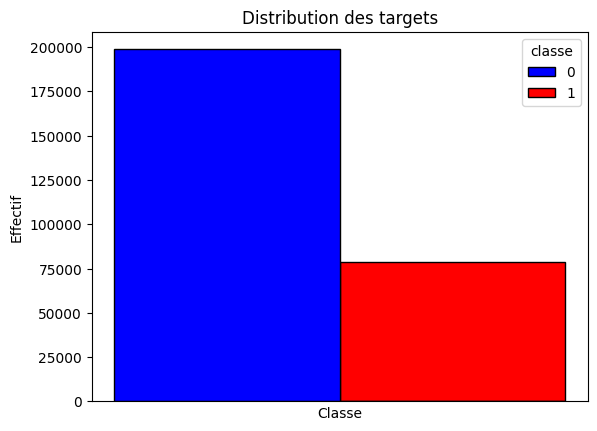

In [19]:
palette = {0: 'blue', 1: 'red'}
g = sns.histplot({"classe":targets},x="classe",discrete=True, hue="classe",palette=palette, alpha=1)
g.set_xlabel("Classe")
g.set_ylabel("Effectif")
g.set_xticklabels([])
g.set_xticks([])
g.set_title("Distribution des targets");

In [20]:
def plot_sample(samples, selected_class):
    sample = dataloader.get_sample(samples,selected_class)
    figure,ax = plt.subplots(1,samples, figsize=(samples,2))
    i = 0
    for key, img in sample.items():
        img = img[0].array
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f"{key}")
        i+=1
    
    plt.suptitle(f"Echantillon de la classe {selected_class}")
    return sample  

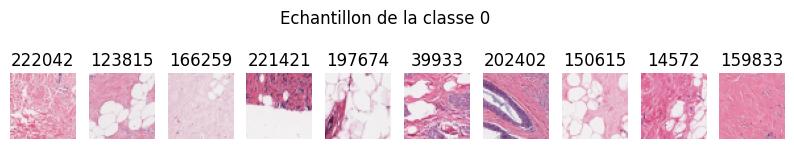

In [21]:
sample =  plot_sample(10, 0)

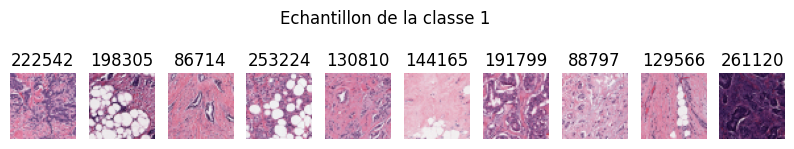

In [22]:
sample =  plot_sample(10, 1)

In [23]:
def get_specter(img):
    red_channel   = img[:, :, 0].reshape(-1)
    green_channel = img[:, :, 1].reshape(-1)
    blue_channel  = img[:, :, 2].reshape(-1)
    
    fig = plt.figure(figsize=(8,3))
    sns.kdeplot(red_channel, color="red", fill=True)
    sns.kdeplot(green_channel, color="green", fill=True)
    g = sns.kdeplot(blue_channel, color="blue", fill=True)
    g.set_ylim(0,0.25)
    g.set_ylabel("Intensité");

In [24]:
def get_mean_specter(img,ax=None):
    red_channel   = img[:, :, 0].mean()
    green_channel = img[:, :, 1].mean()
    blue_channel  = img[:, :, 2].mean()
    #fig = plt.figure(figsize=(8,3))
    ax.axvline(red_channel, 0,1,c="red")
    ax.axvline(green_channel, 0,1,c="green")
    ax.axvline(blue_channel, 0,1,c="blue")
    #ax.set_xlabel("Intensité moyenne");
    ax.set_xlim(0,255)

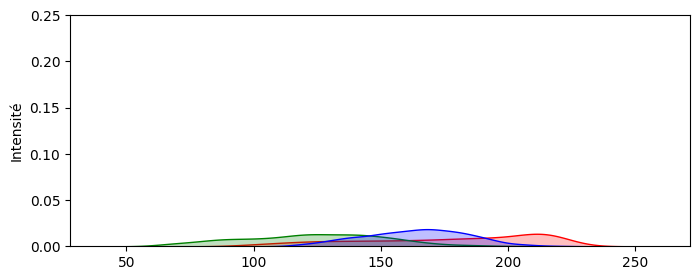

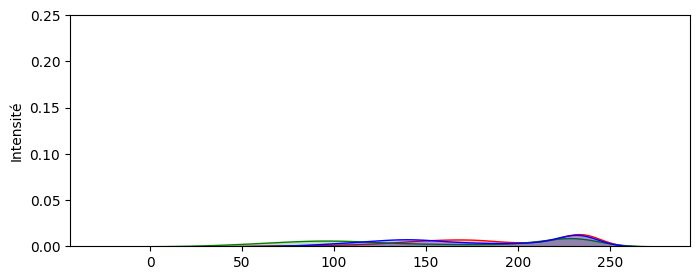

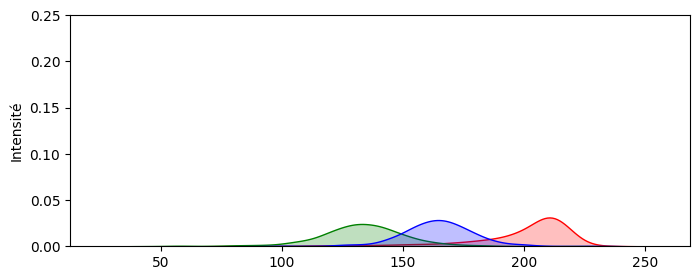

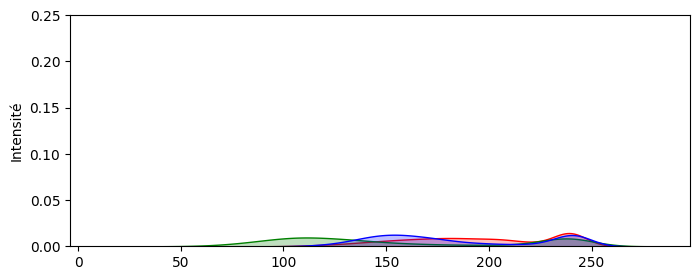

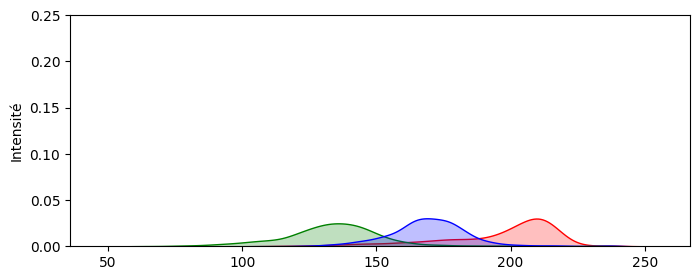

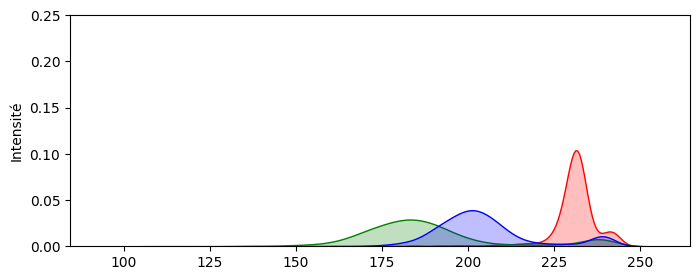

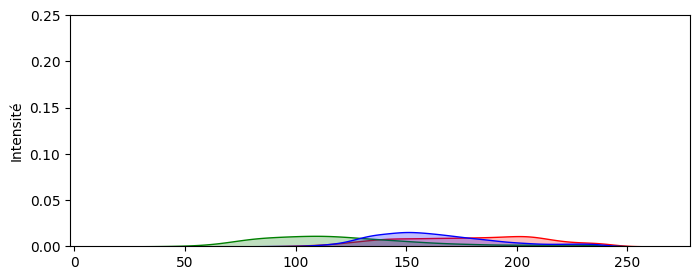

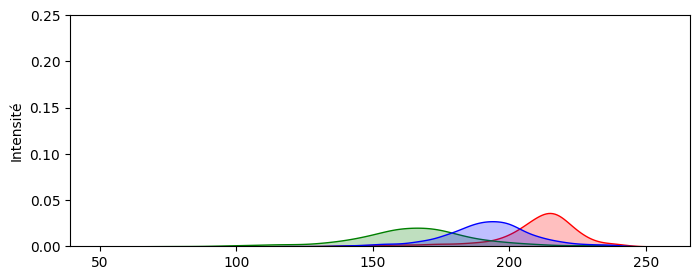

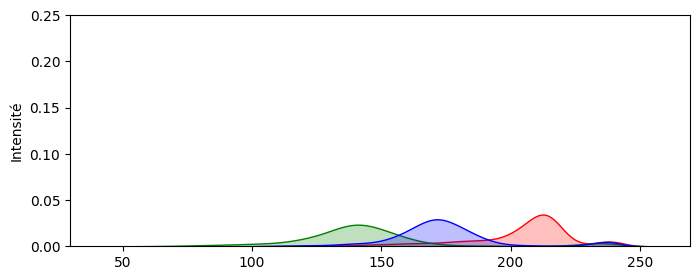

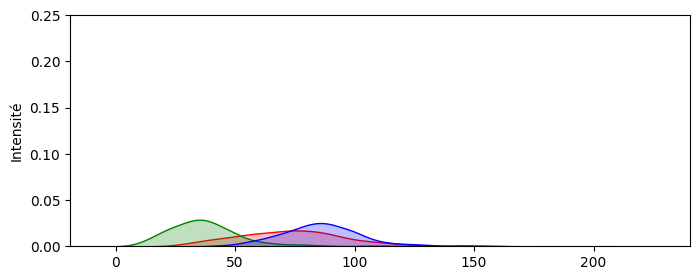

In [25]:
for img in list(sample.values()):
    get_specter(img[0].array)

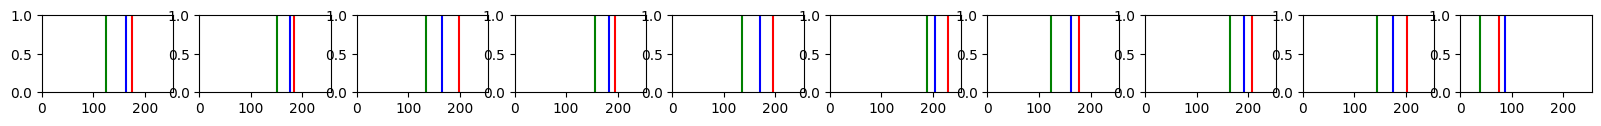

In [26]:
fig, axs =plt.subplots(1,10,figsize=(20,1))
for ax, img in zip(axs,list(sample.values())):
    get_mean_specter(img[0].array,ax)

In [ ]:
def clahe_trnsform(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)

In [ ]:
def plot_clahe(img_rgb, enhanced_img_rgb):
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Amélioré")
    plt.imshow(enhanced_img_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
pix = dataloader.get_sample(10,0).values()
for p in pix:
    plot_clahe(p[0].array, clahe_trnsform(p[0].array))

In [ ]:
type(p)

In [ ]:
p[0].histogram("r")

In [ ]:
len(dataloader)

In [ ]:
columns = [f"{c}_{i}" for c in ["r","g","b" ]for i in range(256)]

In [ ]:
samples = dataloader.get_sample(1000,0)

In [ ]:
len(samples)

In [ ]:
samples = []
for k,v  in dataloader.get_sample(1000,0).items():
    hist = np.concatenate((
        v[0].histogram("r"),
        v[0].histogram("g"),
        v[0].histogram("b")))
    samples.append(hist)
samples = np.array(samples)

In [ ]:
samples.shape

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(samples,columns=columns)

In [ ]:
df.head()

In [ ]:
import seaborn as sns

In [ ]:
sns.kd